### Ноутбук содержит реализацию следующих методов калибровки вероятностей:
1) Histogram Binning
2) Platt calibration
3) Isotonic Regression
4) Probability calibration trees

In [3]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import bisect
from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline 

In [4]:
df = (
    pd.read_csv("../data/cs-training.csv")
    .drop(columns='Unnamed: 0')
    .rename(columns={'SeriousDlqin2yrs': 'target'})
)
df.shape

(150000, 11)

In [5]:
df['target'].value_counts(dropna=False)

target
0    139974
1     10026
Name: count, dtype: int64

In [6]:
df.head()

,target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
features = [f for f in df.columns if f not in ('target', 'id')]
df['segment'] = np.random.choice(['train', 'test'], len(df), p=[0.7, 0.3])

In [8]:
df.isna().mean()

target                                  0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
segment                                 0.000000
dtype: float64

In [9]:
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].mean())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].mean())

In [10]:
# I specifically added class imbalance adjustment(class_weight and is_unbalance parameters)
# without it, the model would have been calibrated fairly well from the start.
models = {
    'lr': LogisticRegression(max_iter=500, class_weight='balanced'),
    'rf': RandomForestClassifier(class_weight='balanced'),
    'lgb': LGBMClassifier(verbose=0, is_unbalance=True)
}

In [11]:
for model_name, model in tqdm(models.items()):
    # print(model)
    model.fit(
        df.query("segment == 'train'")[features],
        df.query("segment == 'train'")['target']
    )
    df[f'pred_proba_{model_name}'] = model.predict_proba(df[features])[:, 1]
    df[f'pred_{model_name}'] = model.predict(df[features])

100%|██████████| 3/3 [00:18<00:00,  6.12s/it]


In [12]:
def calculate_ece(target, proba, folds_count, fold_split='samples'):
    assert fold_split in ['samples', 'scores']
    assert len(target) == len(proba)
    target = np.array(target)
    proba = np.array(proba)
    sorted_ind = proba.argsort()
    n_samples = len(target)
    count_per_fold = n_samples // folds_count
    ece = 0
    mean_probas = []
    mean_targets = []
    if fold_split == 'samples':
        for i in range(folds_count):
            mean_proba = proba[sorted_ind[count_per_fold*i:count_per_fold*(i+1)]].mean()
            mean_target = target[sorted_ind[count_per_fold*i:count_per_fold*(i+1)]].mean()
            ece += abs(mean_proba - mean_target)
            mean_probas.append(mean_proba)
            mean_targets.append(mean_target)
        ece /= folds_count
    else:
        step = 1 / folds_count
        counts = []
        for i in range(folds_count):
            score_cur_ = i * step
            score_next_ = (i + 1) * step
            mask = np.where((proba >= score_cur_) & (proba < score_next_))
            count = len(mask[0])
            if count > 0:
                mean_proba = proba[mask].mean()
                mean_target = target[mask].mean()
                ece += abs(mean_proba - mean_target) * count
                mean_probas.append(mean_proba)
                mean_targets.append(mean_target)
            counts.append(count)
        ece /= sum(counts)
    return ece, mean_probas, mean_targets

0.2366746883584297


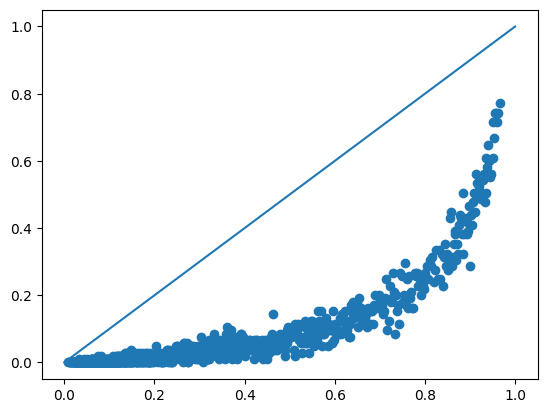

In [13]:
ece, predicted_bins, actual_bins = calculate_ece(
    df.query("segment == 'train'")['target'], 
    df.query("segment == 'train'")[f'pred_proba_lgb'], 
    1000, 
    fold_split='samples'
)
print(ece)
plt.scatter(predicted_bins, actual_bins)
plt.plot([0, 1])
plt.show()

In [14]:
metrics_start = []
for model_name, model in models.items():
    precision, recall, thresholds = precision_recall_curve(df.query("segment == 'train'")['target'], df.query("segment == 'train'")[f'pred_proba_{model_name}'])
    auc_precision_recall_train = auc(recall, precision)
    precision, recall, thresholds = precision_recall_curve(df.query("segment == 'test'")['target'], df.query("segment == 'test'")[f'pred_proba_{model_name}'])
    auc_precision_recall_test = auc(recall, precision)
    metrics_start.append([
        model_name,
        'train', 
        calculate_ece(df.query("segment == 'train'")['target'], df.query("segment == 'train'")[f'pred_proba_{model_name}'], 1000)[0],
        roc_auc_score(df.query("segment == 'train'")['target'], df.query("segment == 'train'")[f'pred_proba_{model_name}']),
        auc_precision_recall_train
    ])
    metrics_start.append([
        model_name,
        'test', 
        calculate_ece(df.query("segment == 'test'")['target'], df.query("segment == 'test'")[f'pred_proba_{model_name}'], 1000)[0],
        roc_auc_score(df.query("segment == 'test'")['target'], df.query("segment == 'test'")[f'pred_proba_{model_name}']),
        auc_precision_recall_test
    ])

In [15]:
pd.DataFrame(metrics_start, columns=['model', 'segment', 'ece', 'roc_auc', 'pr_auc'])

,model,segment,ece,roc_auc,pr_auc
0,lr,train,0.335897,0.813295,0.332247
1,lr,test,0.334094,0.812953,0.331385
2,rf,train,0.034971,0.999867,0.996533
3,rf,test,0.024377,0.830275,0.346354
4,lgb,train,0.236675,0.900122,0.458233
5,lgb,test,0.231284,0.861381,0.391717


In [16]:
class HistCalibrator():
    def __init__(self, n_folds=10):
        self.n_folds = n_folds
    
    def fit(self, proba, target):
        self.score_mapper = [[], []]
        assert len(target) == len(proba)
        target = np.array(target)
        proba = np.array(proba)
        sorted_ind = proba.argsort()
        n_samples = len(target)
        count_per_fold = n_samples // self.n_folds
        ece = 0
        # mean_probas = []
        mean_targets = []
        for i in range(self.n_folds):
            # mean_proba = proba[sorted_ind[count_per_fold*i:count_per_fold*(i+1)]].mean()
            mean_target = target[sorted_ind[count_per_fold*i:count_per_fold*(i+1)]].mean()
            # ece += abs(mean_proba - mean_target)
            # mean_probas.append(mean_proba)
            # mean_targets.append(mean_target)
            self.score_mapper[0].append(proba[sorted_ind[count_per_fold*(i+1)-1]])
            self.score_mapper[1].append(mean_target)
        return self
    
    def predict(self, proba):
        res = []
        for sample in proba:
            for score_ind in range(len(self.score_mapper[0])):
                if sample <= self.score_mapper[0][score_ind]:
                    res.append(self.score_mapper[1][score_ind])
                    break
            else:
                res.append(self.score_mapper[1][-1])
        return np.array(res)
        # return ece, mean_probas, mean_targets

In [17]:
hc = HistCalibrator(n_folds=100)
for model_name, model in models.items():
    hc.fit(df.query("segment == 'train'")[f'pred_proba_{model_name}'], df.query("segment == 'train'")['target']), 
    df[f'histbin_pred_proba_{model_name}'] = hc.predict(df[f'pred_proba_{model_name}'])

In [18]:
lr = LogisticRegression()
for model_name, model in models.items():
    lr.fit(df.query("segment == 'train'")[[f'pred_proba_{model_name}']], df.query("segment == 'train'")['target']), 
    df[f'platt_pred_proba_{model_name}'] = lr.predict_proba(df[[f'pred_proba_{model_name}']])[:, 1]

In [19]:
class IsotonicRegressionCustom():
    def __init__(self):
        self.y_ = []
        self.X_ = []
    
    
    def fit(self, x, y):
        y = y.copy()
        groups = []
        for i in range(len(y)):
            groups.append([x[i], y[i]])
        groups.sort(key=lambda x: x[0])
        x = [el[0] for el in groups]
        y = [[el[1], 1] for el in groups]
        
        i = 0
        history = []
        x_prev = x.copy()
        while i != (len(y) - 1):
            if x[i] == x[i + 1]:
                del x[i + 1]
                new_val = (((y[i][0] * y[i][1]) + (y[i + 1][0] * y[i + 1][1])) / (y[i][1] + y[i + 1][1]))
                new_count = y[i][1] + y[i + 1][1]
                y[i] = [new_val, new_count] 
                del y[i + 1]
                i = max(i - 1, 0)
            else:
                i += 1
        
        i = 0

        while i != (len(y) - 1):
            if y[i][0] > y[i + 1][0]:
                new_val = (((y[i][0] * y[i][1]) + (y[i + 1][0] * y[i + 1][1])) / (y[i][1] + y[i + 1][1]))
                new_count = y[i][1] + y[i + 1][1]
                y[i] = [new_val, new_count] 
                # history.append((i, [row[:] for row in y]))
                del y[i + 1]
                i = max(i - 1, 0)
                
            else:
                i += 1
                
        i = 0
        while i != (len(y) - 1):
            if y[i][0] == y[i + 1][0]:
                new_count = y[i][1] + y[i + 1][1]
                y[i] = [y[i][0], new_count] 
                del y[i + 1]
            else:
                i += 1
                
        prev = 0
        curr = 0
        
        for i in range(len(y)):
            curr += y[i][1]
            self.X_.append(np.min(x_prev[prev]))#:curr
            self.X_.append(np.max(x_prev[curr-1]))#prev:
            self.y_.append(y[i][0])
            self.y_.append(y[i][0])
            # temp_return.append([i, x[prev], x[curr-1], y[i][0], y[i][1]])
            prev = curr
            
            # print(f"Bucket {i}: x from {x[prev]} to {x[curr-1]}, y = {y[i][0]:.5f}, count = {y[i][1]}")
    
        return history
            
    def predict(self, x):
        res = []
        len_x = len(self.X_)
        for x_i in x:
            if x_i <= self.X_[0]:
                res.append(self.y_[0])
            elif x_i >= self.X_[-1]:
                res.append(self.y_[-1])
            else:
                ind_higher = bisect.bisect_right(self.X_, x_i)
                ind_lower = ind_higher - 1

                if x_i == self.X_[ind_lower]:
                    res.append(self.y_[ind_lower])
                else:

                    if self.X_[ind_lower] == self.X_[ind_higher]:
                        res.append(self.y_[ind_lower])
                    else:
                        x_diff = self.X_[ind_higher] - self.X_[ind_lower]
                        y_diff = self.y_[ind_higher] - self.y_[ind_lower]
                        interpolate_share = (x_i - self.X_[ind_lower]) / x_diff
                        y_add = interpolate_share * y_diff
                        res.append(self.y_[ind_lower] + y_add)
        return res
    
    def fit_transform(self, x, y):
        self.fit(x, y)
        return self.predict(x)
    
    def plot(self):
        # from gpt
        import matplotlib.pyplot as plt
        plt.step(self.X_, self.y_, where='post')
        plt.xlabel("Predicted probability")
        plt.ylabel("Calibrated probability")
        plt.title("Isotonic Regression Calibration Curve")
        plt.grid(True)
        plt.show()

In [20]:
def check_pedicts(pred1, pred2, eps=1e-15):
    assert len(pred1) == len(pred2)
    flag = False
    count_bad = 0
    for i in range(len(pred1)):    
        diff = np.abs(pred1[i] - pred2[i])
        if diff > eps:
            flag = True
            count_bad += 1
    return count_bad
    # if flag:
    #     return 'not Ok'
    # return 'Ok'

In [21]:
n = 100_000
x, y = list(df[f'pred_proba_lr'])[:n], list(df['target'])[:n]
irc = IsotonicRegressionCustom()
ir = IsotonicRegression(out_of_bounds='clip')
fit_res = irc.fit(x, y)
ir.fit(x, y)
x, y = list(df[f'pred_proba_lr']), list(df['target'])#np.array(df[f'pred_proba_lr']), np.array(df['target'])#
pred1, pred2 = irc.predict(x), ir.predict(x)
(
    check_pedicts(pred1, pred2),
    list(zip(pred1[::50000], pred2[::50000]))
)

(0,
 [(0.3125572868927589, 0.3125572868927589),
  (0.04238842469940902, 0.04238842469940902),
  (0.041132838840188805, 0.0411328388401888)])

In [22]:
irc = IsotonicRegressionCustom()
for model_name, model in tqdm(models.items()):
    irc.fit(df.query("segment == 'train'")[f'pred_proba_{model_name}'].to_list(), df.query("segment == 'train'")['target'].to_list())
    df[f'isotonic_pred_proba_{model_name}'] = irc.predict(df[f'pred_proba_{model_name}'])

100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


In [23]:
dt = DecisionTreeClassifier(min_samples_leaf=10_000)
dt.fit(df.query("segment == 'train'")[features], df.query("segment == 'train'")['target'])
df['multi_platt_index'] = pd.Series(dt.tree_.apply(df[features].astype(np.float32).to_numpy()))
df['multi_platt_index'].nunique()

8

In [24]:
platt_decision_dict = dict()
for i in tqdm(df['multi_platt_index'].unique()):
    for model_name, model in models.items():
        lr = LogisticRegression()
        mask_pred = (df['multi_platt_index'] == i)
        mask_train = (mask_pred) & (df['segment'] == 'train')
        lr.fit(df.loc[mask_train, [f'pred_proba_{model_name}']], df.loc[mask_train, 'target'])
        df.loc[mask_pred, f'platt_dt_pred_proba_{model_name}'] = lr.predict_proba(df.loc[mask_pred, [f'pred_proba_{model_name}']])[:, 1]
        platt_decision_dict[i] = lr

100%|██████████| 8/8 [00:00<00:00, 24.86it/s]


In [25]:
prefixes = [
    '',
    'histbin_',
    'platt_',
    'isotonic_',
    'platt_dt_',
]
segments = ['train', 'test']

In [26]:
metrics = []
for prefix in tqdm(prefixes):
    for model_name, model in models.items():
        for segment in segments:
            ece, probas, targets = calculate_ece(df.query(f"segment == '{segment}'")['target'], df.query(f"segment == '{segment}'")[prefix + f'pred_proba_{model_name}'], 100)
            metrics.append([prefix, model_name, segment, ece, roc_auc_score(
                    df.query(f"segment == '{segment}'")['target'], df.query(f"segment == '{segment}'")[prefix + f'pred_proba_{model_name}']
                )])
            

100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


In [27]:
metrics_df = pd.DataFrame(metrics, columns=('calibration_method', 'model', 'segment', 'ece', 'roc_auc'))
metrics_df.sort_values(['model', 'calibration_method'])

,calibration_method,model,segment,ece,roc_auc
4,,lgb,train,0.236475,0.900122
5,,lgb,test,0.233329,0.861381
10,histbin_,lgb,train,0.000629,0.900716
11,histbin_,lgb,test,0.010744,0.860157
22,isotonic_,lgb,train,0.002060,0.900438
23,isotonic_,lgb,test,0.010422,0.859652
16,platt_,lgb,train,0.011795,0.900122
17,platt_,lgb,test,0.014842,0.861381
28,platt_dt_,lgb,train,0.010200,0.900869
29,platt_dt_,lgb,test,0.013243,0.860064


In [28]:
metrics_df.query("segment == 'test'").groupby('calibration_method')[['ece', 'roc_auc']].mean()

,ece,roc_auc
calibration_method,,
,0.193264,0.834870
histbin_,0.025870,0.785715
isotonic_,0.025976,0.825925
platt_,0.028104,0.834870
platt_dt_,0.023955,0.839709


In [29]:
metrics_df.query("segment == 'test'").groupby('calibration_method')[['ece', 'roc_auc']].std()

,ece,roc_auc
calibration_method,,
,0.164644,0.024539
histbin_,0.029017,0.089468
isotonic_,0.029421,0.029422
platt_,0.023242,0.024539
platt_dt_,0.022511,0.022298


lr

train
0.2366746883584297


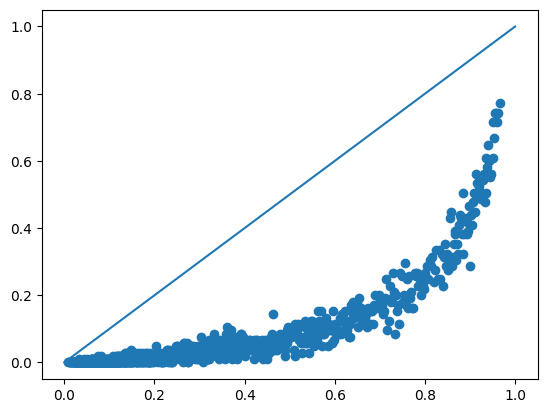

test
0.23128369282274708


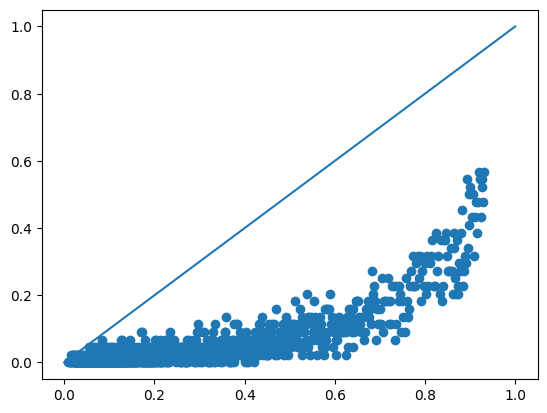

histbin_
train
0.012362257830888986


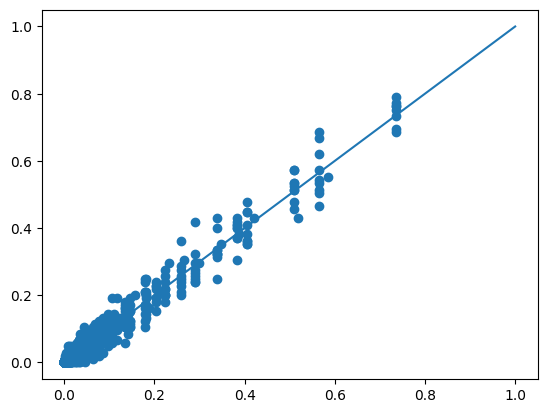

test
0.022629018320082964


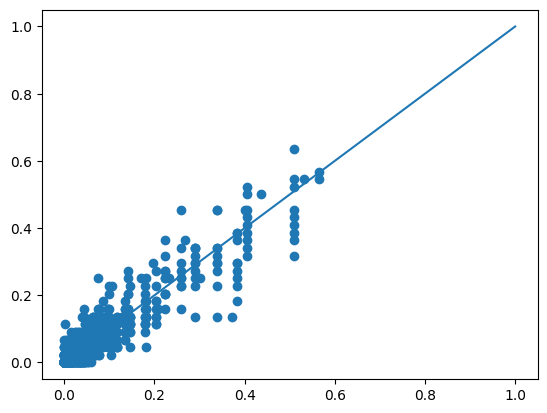

platt_
train
0.016919502967644526


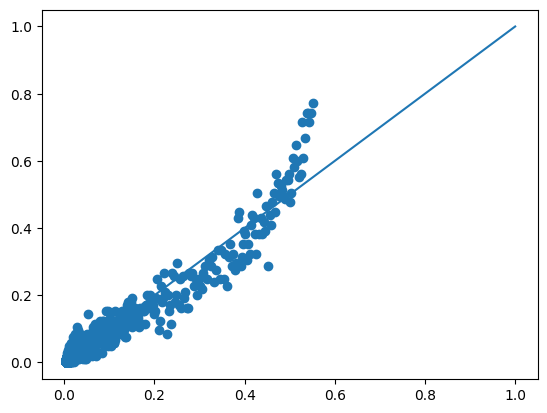

test
0.02431417155854315


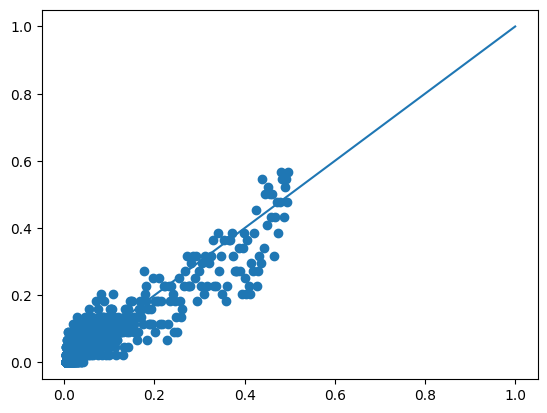

isotonic_
train
0.011643208338840695


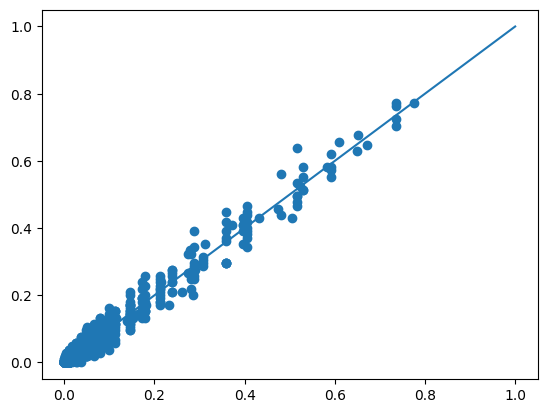

test
0.022451950730320233


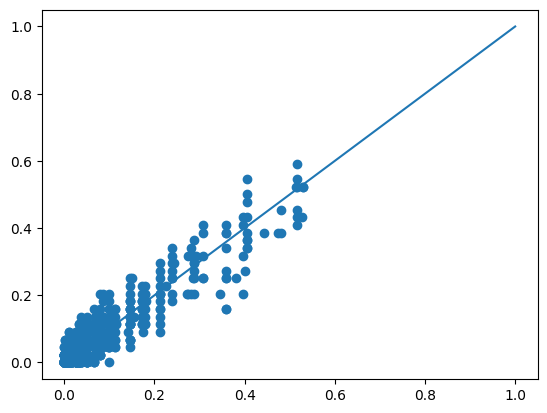

platt_dt_
train
0.016032149073048525


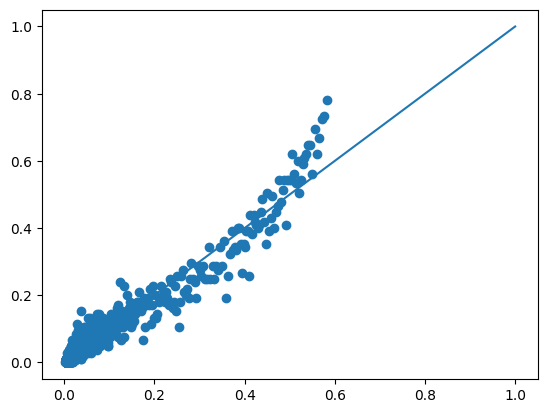

test
0.024494223269991674


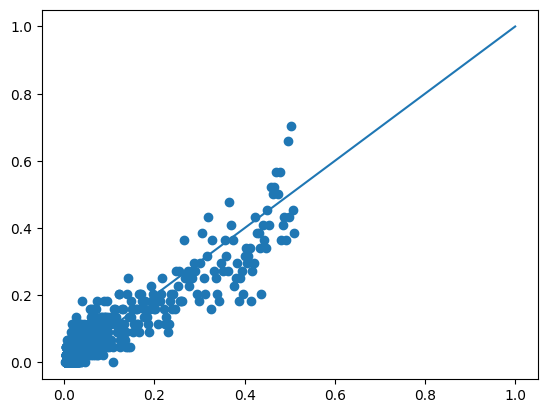

rf

train
0.2366746883584297


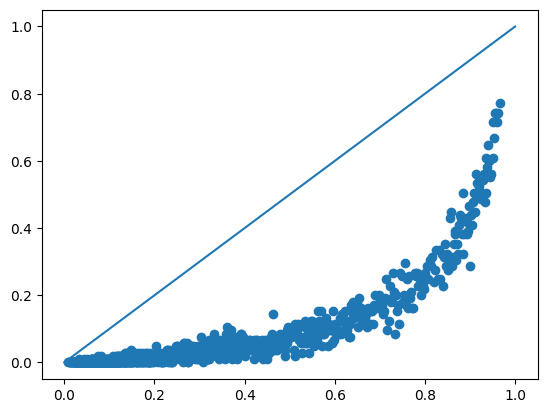

test
0.23128369282274708


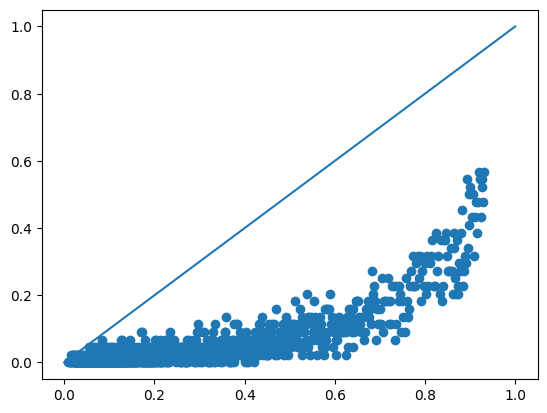

histbin_
train
0.012362257830888986


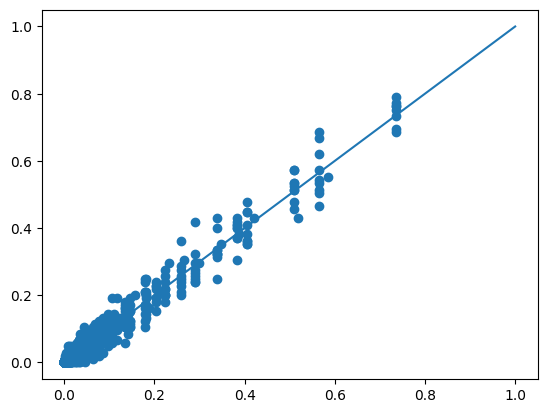

test
0.022629018320082964


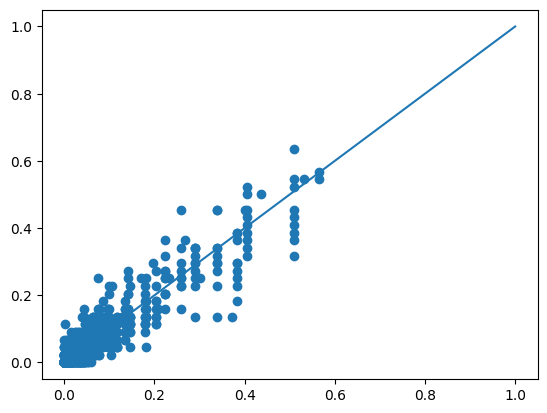

platt_
train
0.016919502967644526


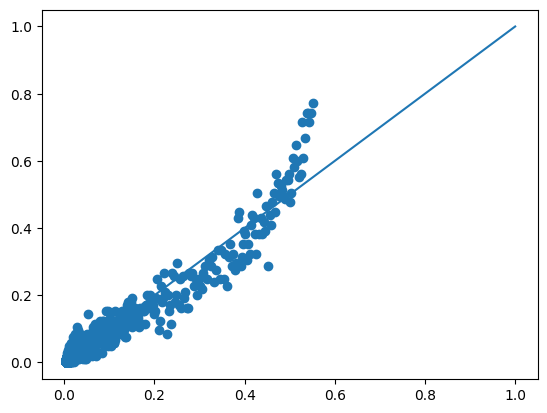

test
0.02431417155854315


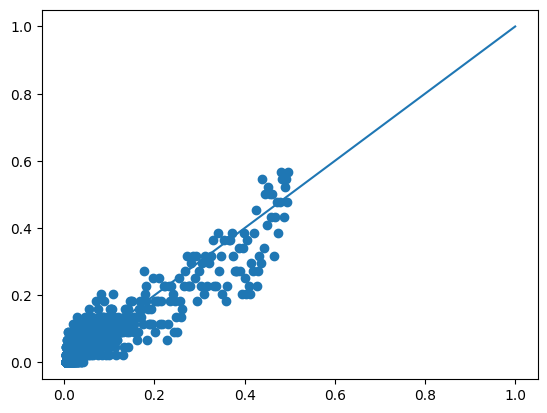

isotonic_
train
0.011643208338840695


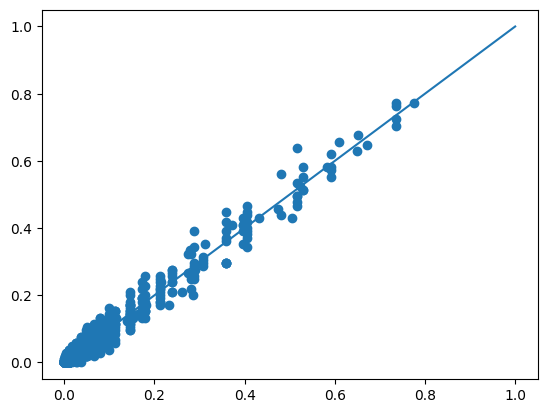

test
0.022451950730320233


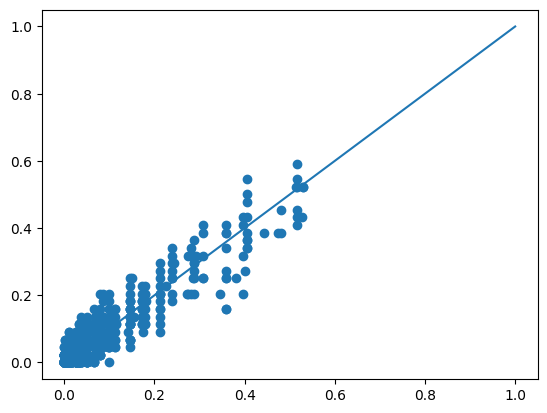

platt_dt_
train
0.016032149073048525


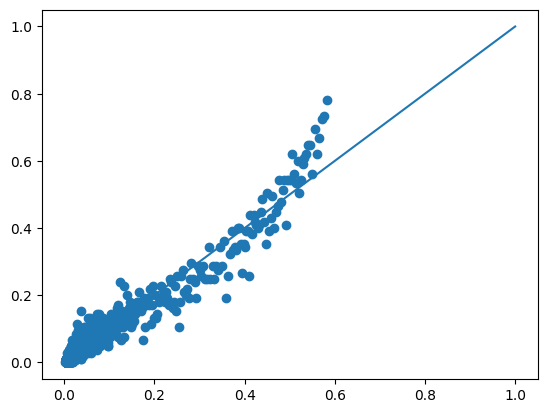

test
0.024494223269991674


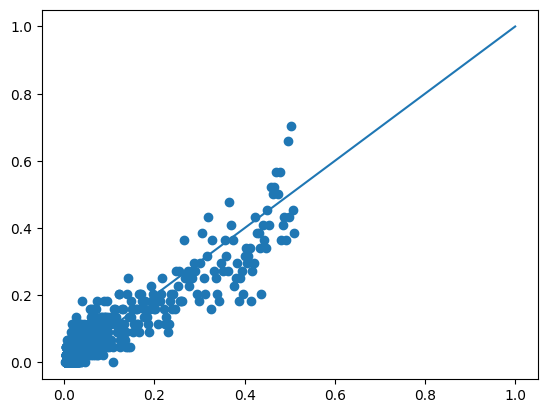

lgb

train
0.2366746883584297


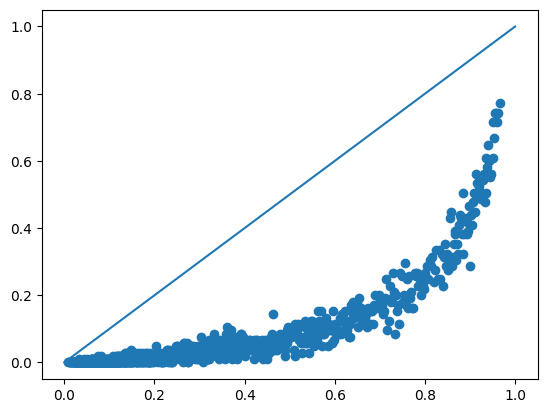

test
0.23128369282274708


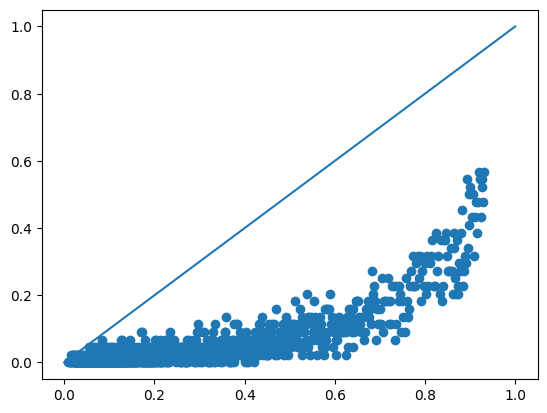

histbin_
train
0.012362257830888986


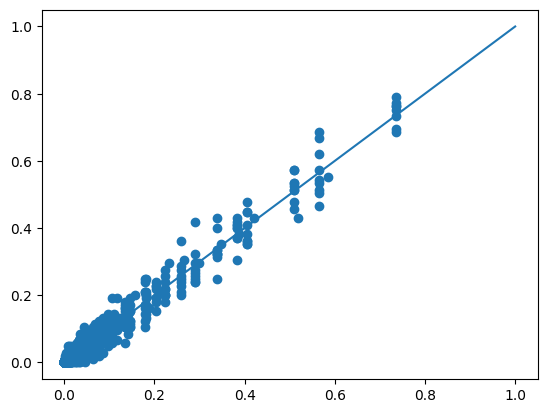

test
0.022629018320082964


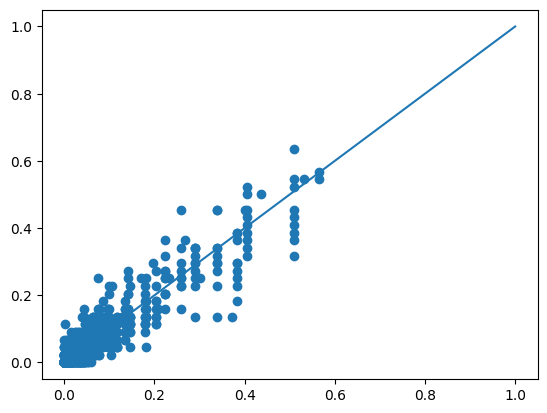

platt_
train
0.016919502967644526


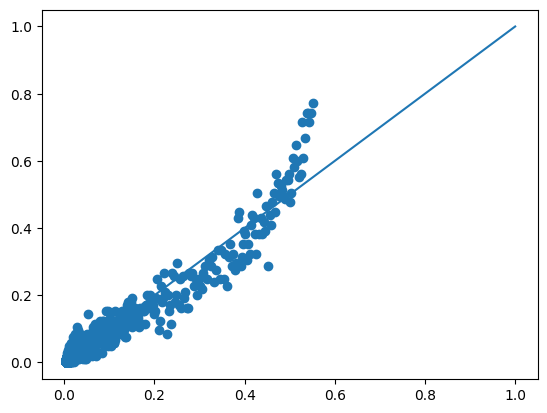

test
0.02431417155854315


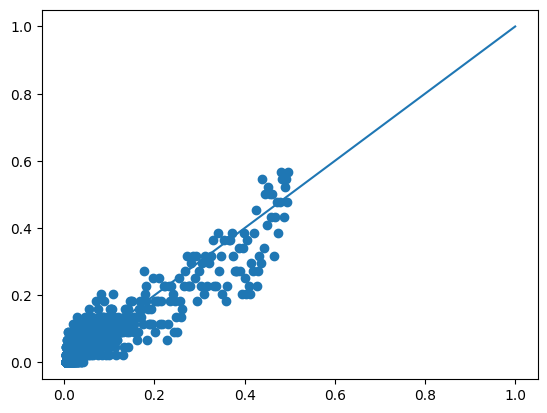

isotonic_
train
0.011643208338840695


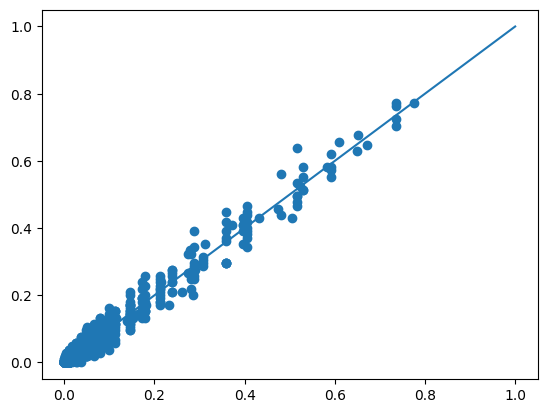

test
0.022451950730320233


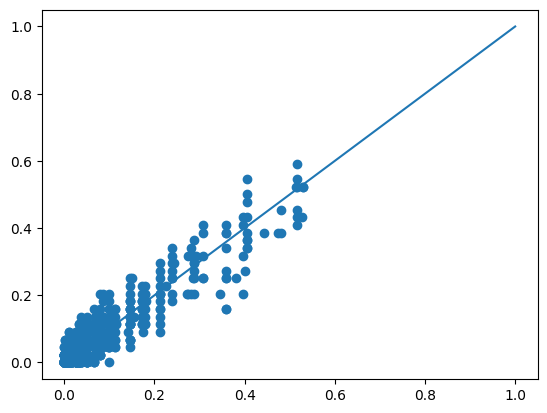

platt_dt_
train
0.016032149073048525


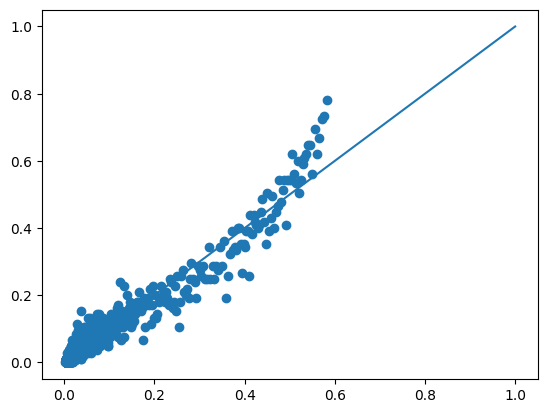

test
0.024494223269991674


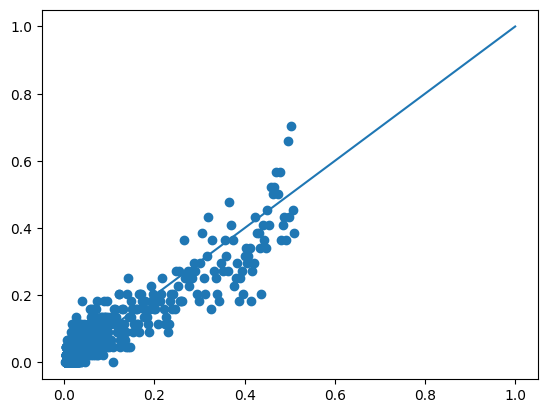

In [30]:
metrics = []
for model_name, model in models.items():
    print(model_name)
    for prefix in prefixes:
        print(prefix)
        for segment in segments:
            print(segment)
            ece, predicted_bins, actual_bins = calculate_ece(
                df.query(f"segment == '{segment}'")['target'], 
                df.query(f"segment == '{segment}'")[prefix + f'pred_proba_lgb'], 
                1000, 
                fold_split='samples'
            )
            print(ece)
            plt.scatter(predicted_bins, actual_bins)
            plt.plot([0, 1])
            plt.show()